<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/NEON_Crop_Sentinel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading gee and drive

In [0]:
import ee

In [2]:
#then we need to authenticate

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=-7g7pwylLgajCUqIN-v8Nl0t3a4VS4bEiuAh_Lv_Ats&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/ywHUJdLhf0C-BxG_rAM4cEcBVw5UIXjjR_7bLzgOKGXM5LMQwXE7OzY

Successfully saved authorization token.


In [3]:
#then we need to authenticate in google drive also so we can upload our download there

from google.colab import drive
drive.mount('/content/drive')
#Perhaps this step can be skipped by saving directly to the workspace

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


First, getting the points from the polygon

In [7]:
!pip install geopandas

import geopandas as gpd

In [0]:

all_ply = gpd.read_file("/content/drive/My Drive/Neon/CustomShape/Comb_FddLMAChl_Centroids_1PtPerLoc_USAonly_Poly.shp")
all_pts = gpd.read_file("/content/drive/My Drive/Neon/CustomShape/Comb_FddLMAChl_Centroids_1PtPerLoc_USAonly.shp")

,SP_ID,ID,geometry
5,6,6,"POLYGON ((-72.22774 42.42909, -72.22774 42.425..."


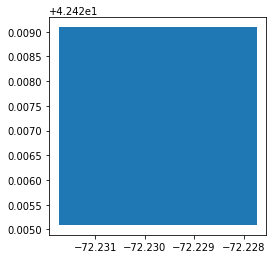

In [83]:
#selecting the first row
sel_ply = all_ply[5:6]
sel_ply.plot()
sel_ply.head()

In [0]:
#https://gis.stackexchange.com/questions/333791/accessing-a-shapefile-with-googleearthengine-api-invalid-geojson-geometry
#selecting a single polygong
#clip_poly = ee.Feature(eval(sel_ply.to_json())['features'][0])
#geojsonDict = jsonDict['features'][0]

#creating a function for extracting coordinates from pandas shapefile
def coords_from_gpd(poly):
  return eval(sel_ply.to_json())['features'][0]['geometry']['coordinates']

clip_poly = ee.Geometry.Polygon(coords_from_gpd(sel_ply))

In [0]:
#Testing the above
# it is quite COMPLEX to use the s2 filters in python
s2_collection = (ee.ImageCollection("COPERNICUS/S2_SR") #selects the S2 Surface reflectance product in GEE
                 .select(['B2','B3','B4',
                          'B5','B6','B7',
                          'B8A','B11','B12']) #selects the bands of interest
                 .filter(ee.Filter.date('2019-06-01','2019-07-01')) #filtes on the time
                 .filterBounds(clip_poly) #filters on the Aoi
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)))

count = s2_collection.size()
print('Nr of images in collection: ', str(count.getInfo())+'\n')

##here is where you select the image
mid_step = s2_collection.toList(count)
s2_img = ee.Image(mid_step.get(0))

#first step now is to then generate a s2 image cropped to our aoi, and for information i will also plot it on the map

# Import the Folium library. This library is to assist in visualizations
import folium

# Import the Image function from the IPython.display module. 
from IPython.display import Image

#the next code snippet i stole from someone
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
visParams = {"bands": ['B4', 'B3', 'B2'],"gain": '0.1, 0.1, 0.1',"scale":20}

# Create a folium map object.
my_map = folium.Map(location=[52.4500, 5.35], zoom_start=12) #this had to be tried one by one... feels daft

# Add the elevation model to the map object.
my_map.add_ee_layer(s2_img, visParams, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)


Ok, now its possible to loop and select 

In [0]:
#create 

In [124]:
print(all_ply.shape)

out_fld = "/content/drive/My Drive/Neon/CustomShape_Clips"

k = 1
for i in range(all_ply.shape[0]):#[0]:#
  print("Processing feature nr:",i+1)
  sel_ply = all_ply[i:(i+1)]
  #print(sel_ply)

  clip_poly = ee.Geometry.Polygon(coords_from_gpd(sel_ply))

  filename = "Poly_"+str(i+1)

  task_config = {
    'image': s2_img,
    'fileFormat': 'GeoTIFF',
    'folder': 'Neon_Clips',
    'fileNamePrefix': filename,
    'description': "clipped area",
    'scale':30,
    'region':clip_poly 
  }
  task = ee.batch.Export.image.toDrive(**task_config )
  task.start()

  flag = task.status()['state']

  while flag != 'COMPLETED':
    flag = task.status()['state']
    #print(k,flag)
    if flag == 'FAILED':

      print("ROWID",k, "GEE task failed")
      flag = 'COMPLETED'

    k = k+1
    

    









(424, 3)
Processing feature nr: 1
Processing feature nr: 2
Processing feature nr: 3
Processing feature nr: 4
Processing feature nr: 5
Processing feature nr: 6
Processing feature nr: 7
Processing feature nr: 8
Processing feature nr: 9
Processing feature nr: 10
Processing feature nr: 11
Processing feature nr: 12
Processing feature nr: 13
Processing feature nr: 14
Processing feature nr: 15
Processing feature nr: 16
Processing feature nr: 17
Processing feature nr: 18
Processing feature nr: 19
Processing feature nr: 20
Processing feature nr: 21
Processing feature nr: 22
Processing feature nr: 23
Processing feature nr: 24
Processing feature nr: 25
Processing feature nr: 26
Processing feature nr: 27
Processing feature nr: 28
Processing feature nr: 29
Processing feature nr: 30
Processing feature nr: 31
Processing feature nr: 32
Processing feature nr: 33
Processing feature nr: 34
Processing feature nr: 35
Processing feature nr: 36
Processing feature nr: 37
Processing feature nr: 38
Processing f

In [114]:
task.status()['state']

'COMPLETED'

In [115]:
flag != 'COMPLETED'
task.status()['state'] != 'COMPLETED'

False